In [1]:
import os, sys
os.environ['PYTHONHASHSEED']=str(0)
import random
random.seed(0)
import numpy as np
np.random.seed(0)
import tensorflow as tf
tf.set_random_seed(0)

# ## uncomment for reproducibility ##
# from keras import backend as K
# session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
# sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
# K.set_session(sess)

import pandas as pd
import matplotlib.pyplot as plt
import pickle
import itertools
import time
import itertools
from IPython.display import display, clear_output

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import SimpleRNN
from keras.initializers import glorot_uniform

from keras.optimizers import Adam
from keras.models import load_model
from keras.callbacks import ModelCheckpoint
from keras.callbacks import Callback

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix


%config InlineBackend.figure_format = 'retina'
%matplotlib inline
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


In [0]:
VERSION = '12'

try:
    import google.colab
    from google.colab import drive

    drive.mount('/content/gdrive')
    root_path = 'gdrive/My Drive/Colab Notebooks/deep_mouse/'
    print('Working on google colab')
except:
    root_path = '../'
    print('Working locally')

directory= f'{root_path}models/{VERSION}'
if not os.path.exists(directory):
    os.makedirs(directory)    
    
sys.path.append(f'{root_path}/rsc/{VERSION}') # Adds pyLi directory to python modules path.
from load_data import load_data
from pre_process_data import pre_process_data
from create_model import create_model
from helper import play_bell, LossHistory, add_grid_and_save
from train_model import train_model
from run_training import run_training
from parameter_space import Parameter_space


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Working on google colab


## Hyperparameters setting

In [0]:
def create_grid(params={}):
    
    grid_file_path = '{}/model_data/grid_{}.pkl'.format(root_path, VERSION)
    
    if os.path.isfile(grid_file_path):
        grid_df = pd.read_pickle(grid_file_path)
        test_index = grid_df['test_index'].max() + 1
    else:
        test_index = 0

    current_grid = {
        'version'                : ['str'     , VERSION],
        'params'                 : ['O'       , params],
        'test_index'             : [np.int    , test_index],
        'root_path'              : ['str'     , root_path],
        'GPU'                    : [np.int    , 1],
        
        # Load and preprocess
        'batch_size_data'        : [np.int    , 200],
        'x_std'                  : [np.float  , 6.],
        'y_std'                  : [np.float  , 5.],
        'sigma_cut'              : [np.float  , 0.1],
        'training_size'          : [np.int    , 5000],
        
        # Metrics
        'best_model_metric'      : ['str'     , 'val_acc'],
        'training_metric'        : ['str'     , 'accuracy'],
        
        # Random seeds
        'seed_skf'               : [np.int    , 0],
        'seed_numpy'             : [np.int    , 0],
        'seed_tensorflow'        : [np.int    , 0],
        'seed_random'            : [np.int    , 0],
        'seed_sklearn'           : [np.int    , 0],
        'seed_model'             : [np.int    , 0],
        
        # Model properties
        'input_shape'            : ['O'       , None],
        'GRU_size'               : [np.int    , 150],
        'dropout'                : [np.float  , 0.],
        'conv_dropout'           : [np.float  , 0.],
        'conv_layers'            : [np.int    , 3],
        'l1_regularizer'         : [np.float  , 0.],
        'l2_regularizer'         : [np.float  , 0.],
        
        # Training parameters
        'learning_rate'          : [np.float  , 1.3e-4],
        'batch_size'             : [np.int    , 128],
        'epochs'                 : [np.int    , 200],
        'test_size'              : [np.float  , 0.15],
        'skf_n_splits'           : [np.int    , 5],
        
        # Outputs
        'best_model_paths'       : ['O'       , []],
        'best_model_accuracies'  : ['O'       , []],
        'fit_outs'               : ['O'       , []]}

    for key, value in params.items():
        current_grid[key][1] = value
    return current_grid

### Run training

In [0]:
# grid = create_grid()

# X_train, X_test, y_train, y_test = load_data(grid)
# X_train, y_train = pre_process_data(X_train, y_train, grid)
# X_test, y_test = pre_process_data(X_test, y_test, grid)

In [0]:
import time
def test_params(next_point_to_probe):
    with open (f'{root_path}log.txt', 'a') as f:
        f.write(f'{time.ctime()}  -  starting {next_point_to_probe}\n')
    print(f'Testing {next_point_to_probe}')

    
    grid = create_grid(next_point_to_probe)
    
    X_train, X_test, y_train, y_test = load_data(grid)
    X_train, y_train = pre_process_data(X_train, y_train, grid)
    X_test, y_test = pre_process_data(X_test, y_test, grid)
    grid = run_training(X_train, y_train, grid, verbose=True)
    
    val_acc_history = [fit_out.history['val_acc'] for fit_out in grid['fit_outs'][1]]
    val_accuracy_estimator = np.mean(val_acc_history, 0)[130:180].mean()
    with open (f'{root_path}log.txt', 'a') as f:
        f.write(f'{time.ctime()}  -  finished {next_point_to_probe}\n')
    
    return val_accuracy_estimator

In [0]:
# %%time


ps = Parameter_space(bounds={
    'training_size' : (50, 1900, 'int')
})



# ps.bayesopt(test_params, kappa=0.25)


# # ## BAYESIAN SEARCH
# grid_file_path = '{}/model_data/grid_{}.pkl'.format(root_path, VERSION)
# if os.path.isfile(grid_file_path):
#     grid_df = pd.read_pickle(grid_file_path)


#     for fo, param in zip(grid_df.fit_outs, grid_df.params):
#         somma = [x.history['val_acc'] for x in fo]    
#         s = np.mean(somma, 0)[130:180].mean()
#         ps.register_point(param, s)

for _ in range(50):
    next_point_to_probe = ps.get_random_next(time_seed=True)
    target = test_params(next_point_to_probe)
# #     ps.register_point(point=next_point_to_probe, target=target)

In [0]:
df = pd.read_pickle('{}/model_data/grid_{}.pkl'.format(root_path, VERSION))

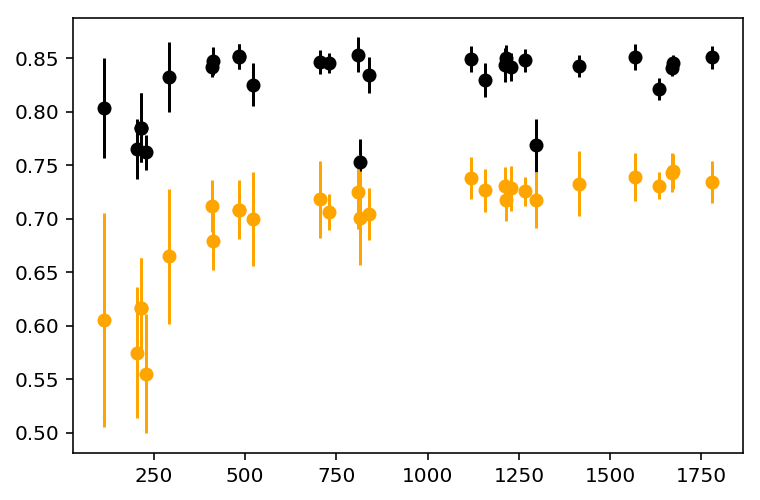

In [0]:
def get_history_data(fit_outs):
    accuracy_list = [x.history['acc'] for x in fit_outs]
    validation_accuracy_list = [x.history['val_acc'] for x in fit_outs]
    
    acc = np.mean(accuracy_list, 0)
    acc_err = np.std(accuracy_list, 0)
    
    val_acc = np.mean(validation_accuracy_list, 0)
    val_acc_err = np.std(validation_accuracy_list, 0)

    return acc, acc_err, val_acc, val_acc_err

def get_history_data_loss(fit_outs):
    accuracy_list = [x.history['loss'] for x in fit_outs]
    validation_accuracy_list = [x.history['val_loss'] for x in fit_outs]
    
    acc = np.mean(accuracy_list, 0)
    acc_err = np.std(accuracy_list, 0)
    
    val_acc = np.mean(validation_accuracy_list, 0)
    val_acc_err = np.std(validation_accuracy_list, 0)

    return acc, acc_err, val_acc, val_acc_err

def get_acc_between(df_row, start=150, stop=180):
    acc_array, acc_err_array, val_acc_array, val_acc_err_array = get_history_data(df_row.fit_outs)
    
    acc = np.mean(acc_array[start:stop])
    acc_err = np.mean(acc_err_array[start:stop])
    
    val_acc = np.mean(val_acc_array[start:stop])
    val_acc_err = np.mean(val_acc_err_array[start:stop])
    
    return acc, acc_err, val_acc, val_acc_err
    
    

def plot_mean_std(df_row, loss=False):
    fit_outs = df_row.fit_outs
    if loss:
        acc, acc_err, val_acc, val_acc_err = get_history_data_loss(fit_outs)
    else:
        acc, acc_err, val_acc, val_acc_err = get_history_data(fit_outs)

    line, = plt.plot(acc)
    plt.fill_between(range(acc.shape[0]), acc-acc_err, acc+acc_err, color=line.get_color(), alpha=0.3)
    
    line, = plt.plot(val_acc)
    plt.fill_between(range(val_acc.shape[0]), val_acc-val_acc_err, val_acc+val_acc_err, color=line.get_color(), alpha=0.3)
    
    plt.title(str(df_row.params))



for index, row in df.iterrows():
    acc, acc_err, val_acc, val_acc_err = get_acc_between(row, start=100, stop=150)
    plt.errorbar(x=row.training_size, y=acc, yerr=acc_err, fmt='o', color='black')
    plt.errorbar(x=row.training_size, y=val_acc, yerr=val_acc_err, fmt='o', color='orange')